In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

In [93]:
df = pd.read_csv('../data/cleaned_dataset.csv')

In [94]:
df.columns

Index(['BHK', 'Price(lakhs)', 'Area', 'Bathrooms', 'Balcony', 'Floor',
       'Total_Floors', 'Store_Room', 'Study_Room', 'Pooja_Room',
       'Servant_Room', 'Property_Age_Years', 'Area_Type_Encoded',
       'Furnishing_Level_Code', 'Facility_Premium', 'Lift', 'Maintenance',
       'WaterStorage', 'VaastuCompliant', 'FireSecurity', 'VisitorParking',
       'Intercom', 'Park', 'AiryRooms', 'Gym', 'Latitude', 'Longitude',
       'Floor_Ratio'],
      dtype='object')

## ElasticNet Regression

In [95]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df_final is your cleaned dataframe
X = df.drop(columns=['Price(lakhs)', 'Latitude', 'Floor'])  # or 'LogPrice' if used
y = df['Price(lakhs)']

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(max_iter=10000, random_state=42))
])

# Define the parameter grid
param_grid = {
    'elastic__alpha': [0.01, 0.1, 1, 10, 100],
    'elastic__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

# GridSearch with 5-fold CV
grid = GridSearchCV(pipeline, param_grid, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

# Best parameters and score
print("✅ Best Hyperparameters:")
print(grid.best_params_)
print(f"📉 Best CV RMSE: {-grid.best_score_:,.2f}")

# Evaluate on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"\n📌 Test RMSE: {test_rmse:,.2f}")
print(f"📌 Test R²:   {test_r2:.4f}")

✅ Best Hyperparameters:
{'elastic__alpha': 1, 'elastic__l1_ratio': 1.0}
📉 Best CV RMSE: 33.54

📌 Test RMSE: 36.50
📌 Test R²:   0.7714


In [117]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import pickle

# -------------------------------
# Step 1: Prepare data
# -------------------------------
# Replace 'df' with your cleaned/preprocessed DataFrame
X = df.drop(columns=['Price(lakhs)', 'Latitude', 'Floor'])  # Features
y = df['Price(lakhs)']                 # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# Step 2: Build Pipeline with Best Hyperparameters
# -------------------------------
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42))
])

# -------------------------------
# Step 3: Train the model
# -------------------------------
elastic_pipeline.fit(X_train, y_train)

# -------------------------------
# Step 4: Evaluate the model
# -------------------------------
# Predict on test set
y_pred = elastic_pipeline.predict(X_test)

# Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

# Cross-validated RMSE
cv_rmse = -cross_val_score(elastic_pipeline, X_train, y_train,
                           scoring='neg_root_mean_squared_error', cv=5).mean()

# Print evaluation results
print("📌 Test MSE:  {:.2f}".format(test_mse))
print("📌 Test RMSE: {:.2f}".format(test_rmse))
print("📌 Test R²:   {:.4f}".format(test_r2))
print("📉 CV RMSE (5-fold): {:.2f}".format(cv_rmse))

# -------------------------------
# Step 5: Save the model
# -------------------------------
joblib.dump(elastic_pipeline, '../models/elasticnet_model.pkl')
joblib.dump(X_train.columns.tolist(), '../models/elasticnet_model_columns.pkl')
print("✅ Model saved as 'elasticnet_model.pkl'")

📌 Test MSE:  1321.22
📌 Test RMSE: 36.35
📌 Test R²:   0.7733
📉 CV RMSE (5-fold): 34.25
✅ Model saved as 'elasticnet_model.pkl'


Top Feature Importances (ElasticNet):
               Feature  Coefficient  Absolute Importance
1                 Area    40.685001            40.685001
4         Total_Floors    13.863203            13.863203
2            Bathrooms     8.569699             8.569699
8         Servant_Room     8.458206             8.458206
10   Area_Type_Encoded    -6.774778             6.774778
6           Study_Room     2.694529             2.694529
9   Property_Age_Years    -2.657569             2.657569
17        FireSecurity     2.435936             2.435936
0                  BHK    -2.289539             2.289539
20                Park    -2.278590             2.278590
22                 Gym    -2.093362             2.093362
3              Balcony    -2.025923             2.025923
13                Lift    -1.908214             1.908214
12    Facility_Premium     1.845625             1.845625
18      VisitorParking    -1.648777             1.648777


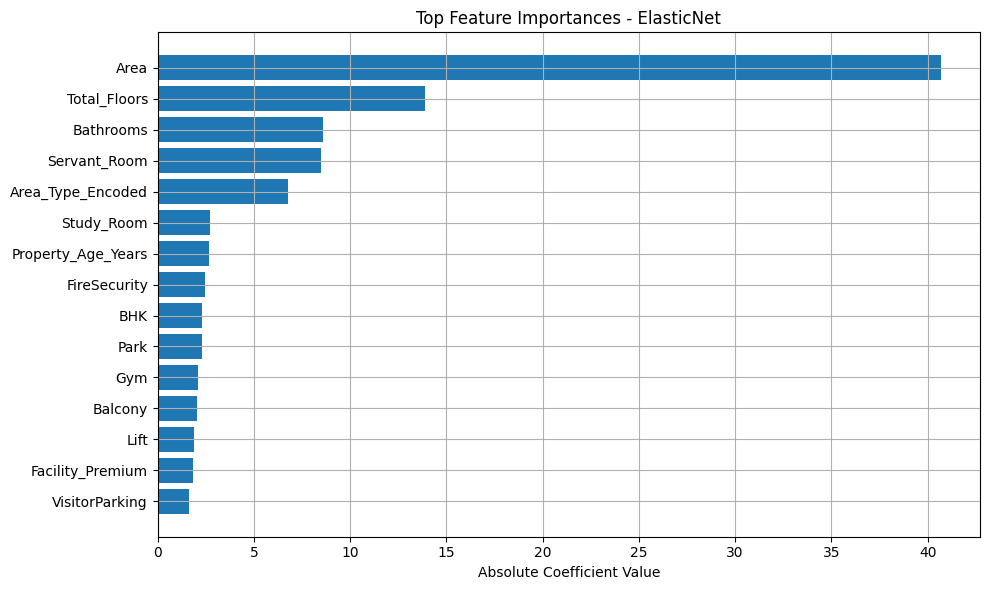

In [97]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load the saved ElasticNet model
elasticnet_model = joblib.load('../models/elasticnet_model.pkl')


# Get feature names used during training
# Replace this with your actual feature names if different
feature_names = X_train.columns  # Ensure X_train is your original DataFrame with the correct columns

# Extract coefficients from the model
coefficients = elasticnet_model.named_steps['elastic'].coef_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Importance': np.abs(coefficients)
})

# Sort by absolute importance
importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)

# Display top N features
top_n = 15
print("Top Feature Importances (ElasticNet):")
print(importance_df.head(top_n))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(top_n)[::-1], importance_df['Absolute Importance'].head(top_n)[::-1])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top Feature Importances - ElasticNet")
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest Regressor

In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Assuming df is your final processed DataFrame (without target leakage or multicollinearity issues)
X = df.drop(columns=['Price(lakhs)'])  # Features
y = df['Price(lakhs)']                 # Target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with scaling and random forest regressor
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=41))
])

# Cross-validation RMSE
cv_scores = cross_val_score(rf_pipeline, X_train, y_train,
                            scoring='neg_root_mean_squared_error', cv=5)
cv_rmse = -np.mean(cv_scores)

# Train model
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

# Output metrics
print(f"📌 Test MSE:  {test_mse:.2f}")
print(f"📌 Test RMSE: {test_rmse:.2f}")
print(f"📌 Test R²:   {test_r2:.4f}")
print(f"📉 CV RMSE (5-fold): {cv_rmse:.2f}")

# Save the trained model
joblib.dump(rf_pipeline, '../models/random_forest_model.pkl')
joblib.dump(X_train.columns.tolist(), '../models/random_forest_model_columns.pkl')
                                        
print("✅ Model saved as 'random_forest_model.pkl'")

📌 Test MSE:  1258.63
📌 Test RMSE: 35.48
📌 Test R²:   0.7840
📉 CV RMSE (5-fold): 35.32
✅ Model saved as 'random_forest_model.pkl'


📊 Top 15 Feature Importances (Random Forest):

           Feature  Importance
              Area    0.535950
         Bathrooms    0.155215
      Total_Floors    0.055309
          Latitude    0.043879
               BHK    0.031627
             Floor    0.029868
       Floor_Ratio    0.022503
         Longitude    0.020503
           Balcony    0.016112
Property_Age_Years    0.015375
      Servant_Room    0.015199
  Facility_Premium    0.009251
 Area_Type_Encoded    0.008686
        Pooja_Room    0.006165
   VaastuCompliant    0.006104


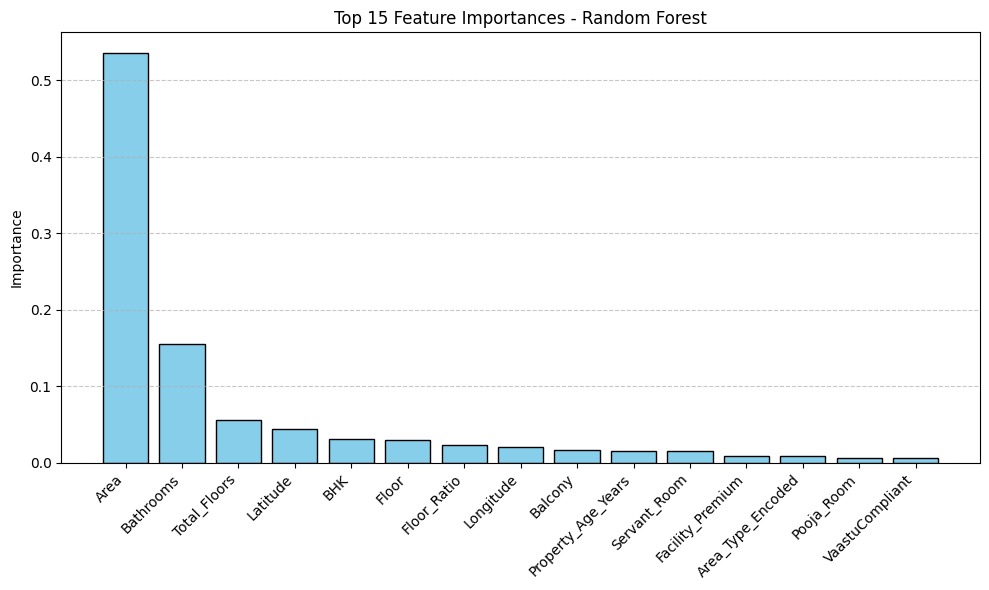

In [99]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the saved model
rf_model = joblib.load('../models/random_forest_model.pkl')

# Extract the RandomForestRegressor from pipeline
rf = rf_model.named_steps['rf']

# Get feature names used during training
feature_names = X.columns  # Make sure X matches the training data features

# Get feature importances and sort
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15  # top N features

# Prepare DataFrame for display
top_features = [(feature_names[i], importances[i]) for i in indices[:top_n]]
importance_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])

# Print in text form
print("📊 Top 15 Feature Importances (Random Forest):\n")
print(importance_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.bar(range(top_n), importances[indices[:top_n]], align='center', color='skyblue', edgecolor='black')
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.ylabel("Importance")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Gradient Boosting

In [100]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming df is your final processed DataFrame (without target leakage or multicollinearity issues)
X = df.drop(columns=['Price(lakhs)'])  # Features
y = df['Price(lakhs)']                 # Target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the pipeline
gbr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gbr', GradientBoostingRegressor(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'gbr__n_estimators': [100, 200, 300],
    'gbr__learning_rate': [0.01, 0.05, 0.1],
    'gbr__max_depth': [3, 4, 5],
    'gbr__min_samples_split': [2, 5, 10]
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=gbr_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # CV scoring
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = -grid_search.best_score_  # Convert back to positive RMSE

# Evaluate on test set
y_pred = best_gbr_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

# Print results
print("✅ Best Hyperparameters:")
print(best_params)
print(f"📉 Best CV RMSE: {best_cv_score:,.2f}")
print(f"\n📌 Test MSE:  {test_mse:,.2f}")
print(f"📌 Test RMSE: {test_rmse:,.2f}")
print(f"📌 Test R²:   {test_r2:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best Hyperparameters:
{'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__min_samples_split': 10, 'gbr__n_estimators': 300}
📉 Best CV RMSE: 33.71

📌 Test MSE:  965.28
📌 Test RMSE: 31.07
📌 Test R²:   0.8344


In [121]:
import numpy as np
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df is your final processed DataFrame (without target leakage or multicollinearity issues)
X = df.drop(columns=['Price(lakhs)'])  # Features
y = df['Price(lakhs)']                 # Target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with best hyperparameters
gbr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gradientboosting', GradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=10,
        n_estimators=300,
        random_state=42
    ))
])

# Train the model
gbr_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = gbr_pipeline.predict(X_test)

# Evaluate performance
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

# Print evaluation
print(f"📌 Test MSE:  {test_mse:,.2f}")
print(f"📌 Test RMSE: {test_rmse:,.2f}")
print(f"📌 Test R²:   {test_r2:.4f}")

# Save model
joblib.dump(gbr_pipeline, '../models/gradient_boosting_model.pkl')
joblib.dump(X_train.columns.tolist(), '../models/gradient_boosting_model_columns.pkl')

print("✅ Model saved as 'gradient_boosting_model.pkl'")


📌 Test MSE:  965.28
📌 Test RMSE: 31.07
📌 Test R²:   0.8344
✅ Model saved as 'gradient_boosting_model.pkl'


📊 Feature Importances (Descending):
              Feature  Importance
                 Area    0.489995
            Bathrooms    0.187343
             Latitude    0.066417
                  BHK    0.046479
         Total_Floors    0.045177
         Servant_Room    0.041487
                Floor    0.030337
            Longitude    0.025841
              Balcony    0.025807
          Floor_Ratio    0.012956
     Facility_Premium    0.008204
           Store_Room    0.006327
    Area_Type_Encoded    0.005704
      VaastuCompliant    0.001846
           Pooja_Room    0.001145
           Study_Room    0.001108
   Property_Age_Years    0.001051
Furnishing_Level_Code    0.000840
         FireSecurity    0.000567
         WaterStorage    0.000514
                 Lift    0.000279
            AiryRooms    0.000204
       VisitorParking    0.000144
             Intercom    0.000098
                 Park    0.000072
                  Gym    0.000058
          Maintenance    0.000000


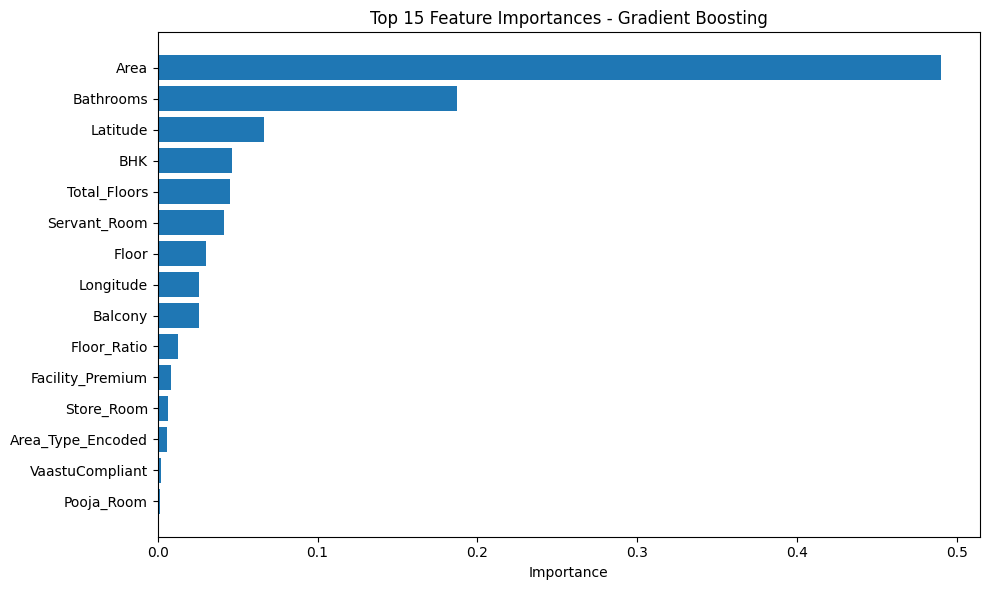

In [102]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the trained model
gbr_pipeline = joblib.load('../models/gradient_boosting_model.pkl')

# Get feature importances from the Gradient Boosting Regressor
# Extract the trained regressor from the pipeline
gbr_model = gbr_pipeline.named_steps['gbr']

# Replace with your actual feature names used during training
feature_names = X_train.columns

# Create a DataFrame for feature importances
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gbr_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print feature importances as text
print("📊 Feature Importances (Descending):")
print(importances.to_string(index=False))

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'][:15][::-1], importances['Importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Gradient Boosting')
plt.tight_layout()
plt.show()


## XGBoost Regressor

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# param_grid = {
#     'xgb__n_estimators': [100, 200, 300],
#     'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'xgb__max_depth': [3, 5, 7],
#     'xgb__subsample': [0.6, 0.8, 1.0],
#     'xgb__colsample_bytree': [0.6, 0.8, 1.0]
# }


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgb__colsample_bytree': [0.8, 1.0], 'xgb__learning_rate': [0.05, 0.1], 'xgb__max_depth': [3, 5], 'xgb__n_estimators': [100, 200], ...}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [104]:
import pandas as pd

results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score']])


                                               params  mean_test_score
0   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -36.337620
1   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -35.545450
2   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -35.226298
3   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -34.315386
4   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -35.184241
5   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -35.982471
6   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -34.553976
7   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -35.392342
8   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -34.970879
9   {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -34.366370
10  {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -34.442414
11  {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -33.955835
12  {'xgb__colsample_bytree': 0.8, 'xgb__learning_...       -34.494069
13  {'

In [105]:
results['RMSE'] = -results['mean_test_score']
best_idx = results['RMSE'].idxmin()
best_params = results.loc[best_idx, 'params']
best_rmse = results.loc[best_idx, 'RMSE']
print(f"✅ Best Hyperparameters:\n{best_params}")
print(f"📉 Best CV RMSE: {best_rmse:,.2f}")

✅ Best Hyperparameters:
{'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
📉 Best CV RMSE: 33.49


In [120]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib

# Assuming df is your final processed DataFrame (without target leakage or multicollinearity issues)
X = df.drop(columns=['Price(lakhs)'])  # Features
y = df['Price(lakhs)']                 # Target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline with best parameters

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor(
        colsample_bytree=1.0,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=200,
        subsample=0.8,
        random_state=40,
        n_jobs=-1
    ))
])


# Train the model
xgb_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Cross-validation score (5-fold CV RMSE)
cv_rmse = -cross_val_score(xgb_pipeline, X_train, y_train,
                           scoring='neg_root_mean_squared_error', cv=5).mean()

# Print evaluation
print(f"📌 Test MSE:  {mse:.2f}")
print(f"📌 Test RMSE: {rmse:.2f}")
print(f"📌 Test R²:   {r2:.4f}")
print(f"📉 CV RMSE (5-fold): {cv_rmse:.2f}")

# Save model
joblib.dump(xgb_pipeline, '../models/xgboost_model.pkl')
joblib.dump(X_train.columns.tolist(), "../models/xgboost_model_columns.pkl")

print("✅ Model saved as 'xgboost_model.pkl'")

📌 Test MSE:  918.10
📌 Test RMSE: 30.30
📌 Test R²:   0.8425
📉 CV RMSE (5-fold): 33.26
✅ Model saved as 'xgboost_model.pkl'


📌 Feature Importances:
Servant_Room: 0.3368
Area: 0.1367
Bathrooms: 0.1134
BHK: 0.0568
Floor: 0.0463
Latitude: 0.0397
VaastuCompliant: 0.0341
Total_Floors: 0.0318
AiryRooms: 0.0316
Facility_Premium: 0.0207
Floor_Ratio: 0.0191
Longitude: 0.0179
VisitorParking: 0.0174
Balcony: 0.0155
Area_Type_Encoded: 0.0124
FireSecurity: 0.0113
Pooja_Room: 0.0109
Study_Room: 0.0108
Furnishing_Level_Code: 0.0072
Lift: 0.0065
Maintenance: 0.0061
Property_Age_Years: 0.0048
WaterStorage: 0.0042
Intercom: 0.0027
Store_Room: 0.0024
Park: 0.0018
Gym: 0.0013


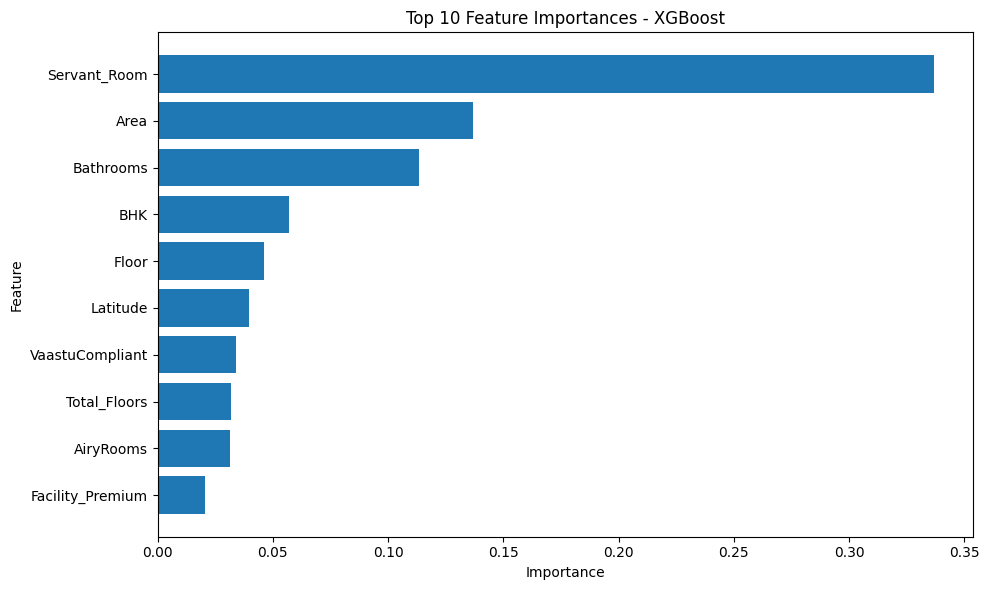

In [107]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the trained pipeline
xgb_pipeline = joblib.load('../models/xgboost_model.pkl')

# Extract the trained XGBRegressor model
xgb_model = xgb_pipeline.named_steps['xgb']

# Get feature importances
importances = xgb_model.feature_importances_

# Get feature names (ensure they match your training features)
feature_names = X_train.columns  # Replace with actual column list if needed

# Create DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print feature importances as text
print("📌 Feature Importances:")
for i, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Plot top 10
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


UrbanNest — ML-Powered Flat Price Estimator

Developed an interactive Streamlit app for predicting flat prices in Kolkata using models like XGBoost, Random Forest, and Gradient Boosting. Integrated SHAP-based model explainability (force plot, waterfall chart) to visually interpret how user inputs affect price predictions, enhancing transparency and trust in the system.